(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [42]:
'''
thought: calc the score using text words and arrange the users from lower
score to higher score.  Then plot their calculated score and 
actual rating(star).  It should match in trend(both growing or decreasing)
'''
from nltk.stem.porter import PorterStemmer
import pandas as pd
from pandas import DataFrame
import numpy as np
import unicodedata
import json
import csv
import os

porter = PorterStemmer()

reviewFile = open(
        './yelp_dataset/yelp_academic_dataset_review.json',
        'r'
)

lexion_pos = open(
    './positive-words.txt',
    'r'
)

lexion_neg = open(
    './negative-words.txt',
    'r'
)

pos_lst = np.array([])
neg_lst = np.array([])

for line in lexion_pos:
    if line[0] is not ';':
        pos_lst = np.append(pos_lst, line[:-1])
    else:
        pass
    
for line in lexion_neg:
    if line[0] is not ';':
        neg_lst = np.append(neg_lst, line[:-1])
    else:
        pass

print pos_lst
print neg_lst

['' 'a+' 'abound' ..., 'zenith' 'zest' 'zippy']
['' '2-faced' '2-faces' ..., 'zealous' 'zealously' 'zombie']


In [44]:
#readfile by line and calc score, save to a dataframe
import time


def calc_line(review_string, print_bool):
    start_time = time.time()
    review_score = 0.0
    #apply porter stemming to review string
    porter = PorterStemmer()
    review_string = porter.stem(review_string)
    review_string = unicodedata.normalize('NFKD', review_string).encode('ascii','ignore').lower()
    review_token_lst = whitespace_tokenize(review_string)
    if print_bool:
        time1 = time.time()
        print '    2.1: ' + str(time1 - start_time)
    pos_words = np.intersect1d(review_token_lst, pos_lst)
    neg_words = np.intersect1d(review_token_lst, neg_lst)
    review_score = review_score + len(pos_words) - len(neg_words)
    if print_bool:
        time2 = time.time()
        print '    2.2: ' + str(time2 - time1)
    #normalize to 0~5
    if len(pos_words) + len(neg_words) is not 0:
        review_score = (review_score * 2.5) / (1.0 * len(pos_words) + len(neg_words)) + 2.5
    else:
        review_score = 0
    del(pos_words)
    del(neg_words)
    if print_bool:
        time3 = time.time()
        print '    2.3: ' + str(time3 - time2)
        print '    --------------------------'
    return review_score

def whitespace_tokenize(review_string):
#     token_lst = ['!', '.', ',', '?']
#     for token in token_lst:
#         review_string = review_string.replace(token , '')
    review_token_lst = review_string.split(' ')
    return np.array(review_token_lst)
    
def calc_score(reviewFile):
    #open file
    os.system("rm score_dataframe.csv")
    os.system("touch score_dataframe.csv")
    score_df = open('score_dataframe.csv', 'r+b')
    #create header
    columns = ['review_id','star','calculated_id']

    writerFile = csv.writer(score_df, delimiter=',')
    writerFile.writerow(columns)
    
    start_time = time.time()
    one_k_time = time.time()
    scoreDF = DataFrame(columns = [
        'review_id', 
        'stars', 
        'calcuated_score'
        ])
    i = 0
#     star_lst = np.array([])
#     review_score_lst = np.array([])
    for line in reviewFile:
        start_time = time.time()
        i = i + 1
        json_dict = json.loads(line)
        review_id = json_dict['review_id']
        stars = json_dict['stars']
        review_string = json_dict['text']
#         if i % 1000 == 0:
#             time1 = time.time()
#             print '1: ' + str(time1 - start_time)
        #calc score for line
#         if i % 1000 == 0:
#             review_score = calc_line(review_string, True)
#         else:
#             review_score = calc_line(review_string, False)
        review_score = calc_line(review_string, False)
#         if i % 1000 == 0:
#             time2 = time.time()
#             print '2: ' + str(time2 - time1)
        
        #write to df 
        writerFile.writerow([review_id, stars, review_score])
#         if i % 1000 == 0:
#             time3 = time.time()
#             print '3: ' + str(time3 - time2)
#             print '============================'
        if i % 10000 == 0:
            print i / 1000
            print time.time() - one_k_time
            one_k_time = time.time()
    #sort df by calculated_score

In [45]:
#starts at 5:25pm , ends at 6:12pm
calc_score(reviewFile)

10
13.2851409912
20
12.9712920189
30
12.2607479095
40
12.4290771484
50
12.9657030106
60
12.5651361942
70
13.92887187
80
12.8639850616
90
12.166962862
100
12.3563640118
110
12.4332888126
120
12.1241641045
130
12.7519049644
140
12.7115001678
150
12.3237378597
160
12.1325669289
170
12.6379811764
180
12.5478820801
190
12.1739521027
200
12.2801749706
210
12.3600649834
220
12.2327570915
230
12.3462669849
240
12.2451648712
250
12.6324760914
260
12.7909061909
270
12.471339941
280
12.2713069916
290
12.3057911396
300
12.0924599171
310
12.0962879658
320
12.2568199635
330
12.8580260277
340
12.8921380043
350
12.576089859
360
12.2852580547
370
12.4081480503
380
12.5837180614
390
12.3584358692
400
12.475538969
410
12.5803539753
420
12.4042050838
430
12.4728090763
440
12.3358139992
450
12.1875069141
460
12.265529871
470
12.4361248016
480
12.4865617752
490
12.6746809483
500
13.3974039555
510
13.2971539497
520
12.7035191059
530
13.1348760128
540
12.4574391842
550
12.8709290028
560
12.853000164
570
12.50

Visualization and short (detailed) analysis. **(10 pts)**

In [46]:
#read both dataframe and visualize
import pandas as pd
review_df = pd.read_csv('./score_dataframe.csv')

In [47]:
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def plotSeries(series, series2):
    plt.figure(figsize=(20,10))
    plt.plot(series)
#     plt.plot(series2)
    plt.xlabel('id')
    plt.ylabel('star')


/home/gladius/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [48]:
review_df = review_df.sort(['star', 'calculated_id'], ascending=[1 , 1])

/home/gladius/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


(0, 5)

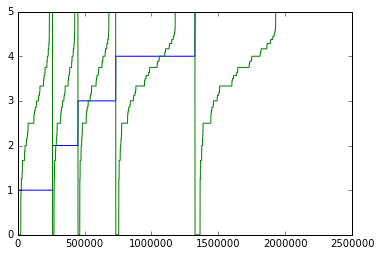

In [49]:
# star_series = review_df['star']
# score_series = review_df['calculated_id']
# review_df.star.plot(label='star', linewidth=2)
star = np.array(review_df.star.values)
score = np.array(review_df.calculated_id.values)
plt.plot(star)
plt.plot(score)
plt.ylim(0 , 5)

For most of posts that gives 5 stars, the calculated score is 5.  The score we got from sentiment analysis here is actually the ratio of pos word and neg words.  In those reviews that has 5 stars and 5 calculated scores, there must be no negative words in the review text.  However there might be negation works like "not bad" but the bad is calculated as a negative word so there might be cases that people give 5 stars and we got like 3 or 4 calculated scores.  Also there might be people giving 1 or two stars but has a pretty high score, sometimes even 5, in this case negation is also a possible answer, and some people prefer not to use too much negative words, instead they might use "they lost my business for good" in which good might be considered a positive word.

-----------------

Now, let's look at Business Objects. Try to find **culinary districts in Las Vegas**. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to **cluster closeness**. Use "categories" and "attributes" to **cluster for similarity**.

Find clusters using the 3 different techniques we discussed in class: **k-means++**, **hierarchical**, and **GMM**. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The **spatial coordinates** and **restaurant categories/attributes** have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [1]:
import json
import csv
import os
import unicodedata
import pandas as pd
import numpy as np
#calc attribute value and store them as an int
#when retrieving it, for int a and int b, 
#bin(a ^ b).count("1") is the hamming distance
#currently the hamming distance for attributes will be 0 to 5
def calc_attrib(attrib_dict):
    score = 0
    if 'Delivery' in attrib_dict and attrib_dict['Delivery']:
        score = score + 1
    score = score * 2
    if 'Accepts Credit Cards' in attrib_dict and  attrib_dict['Accepts Credit Cards']:
        score = score + 1
    score = score * 2
    if 'Take-out' in attrib_dict and  attrib_dict['Take-out']:
        score = score + 1
    score = score * 2
    if 'Wi-Fi' in attrib_dict and  attrib_dict['Wi-Fi'] == u'no':
        score = score + 1
    score = score * 2
    if 'Waiter Service' in attrib_dict and  attrib_dict['Waiter Service']:
        score = score + 1
    return score
    
#get data filtered
def get_restaurants():
    business_file = open('./yelp_dataset/yelp_academic_dataset_business.json' , 'r')
    i = 0
    #create csv file for restaurants
    os.system("rm restaurant_dataframe.csv")
    os.system("touch restaurant_dataframe.csv")
    restaurant_df = open('restaurant_dataframe.csv', 'r+b')

    #open csv file for restaurants
    columns = ['name', 'latitude', 'longitude', 'categories', 'bool_attrib']
    writerFile = csv.writer(restaurant_df)
    writerFile.writerow(columns)
    for line in business_file:
        tempDict = json.loads(line)
        if tempDict['city'] == u'Las Vegas':
            if u'Restaurants' in tempDict['categories']:
                i = i + 1
                ascii_list = ''
                for cat in tempDict['categories']:
                    ascii_list += str(cat)
                    ascii_list += ';'
                #write to df 
                writerFile.writerow([
                    unicodedata.normalize('NFKD', tempDict['name']).encode('ascii','ignore'),
                    tempDict['latitude'],
                    tempDict['longitude'],
                    ascii_list,
                    calc_attrib(tempDict['attributes'])
                ])
    business_file.close()
get_restaurants()

In [2]:
#calculate attribute distance(0-5) 0 is similar
def calc_dist_attrib(a , b):
    return bin(a ^ b).count("1") * 1.0 / 5

#calculate space diatance(1000 * dist^2)/17 => (0-10) 0 is closest
def calc_dist_space(x1, y1, x2, y2):
    return (1000 * ((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))) / 17

#calculate category(0-5) 0 is similar
def calc_dist_category(lst1 , lst2):
    return (1 - len(set(lst1) & set(lst2)) / len(set(lst1) | set(lst2)))

In [3]:
# def calc_bussiness_dist():
import time
dist_df = pd.read_csv("./restaurant_dataframe.csv")
lon = dist_df.longitude
lat = dist_df.latitude
dist = dist_df.bool_attrib
cat = dist_df.categories

start = time.time()
dist_array = []
for i in range(0, len(dist_df)):
    temp_array = np.array([0.0 for i in range(0, len(dist_df))])
    dist_array.append(temp_array)
dist_array = np.array(dist_array)
for i in range(0 , len(dist_df)):
    for j in range(i, len(dist_df)):
        tempDist = 0.0
        tempDist += calc_dist_space(lon[i], lat[i], lon[j], lat[j])
        tempDist += calc_dist_attrib(dist[i] , dist[j])
        tempDist += calc_dist_category(
                        cat[i].split(';'), 
                        cat[j].split(';')
                    )
        dist_array[i][j] = tempDist
    print i
print time.time() - start
dist_array = dist_array + dist_array.T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Visualize your clusters using **each technique**. Label your clusters. **(10 pts)**

In [6]:
#read data frame
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline

restaurant_df = pd.read_csv('./restaurant_dataframe.csv')
colors = ['#0000FF', '#00FF00', '#FF0000', '#FFFF00', '#00FFFF',
          '#FF00FF', '#7777FF', '#FF7777', '#FF77FF', '#5B8324']

In [7]:
#kmeans++
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10)
kmeans.fit_predict(dist_array)
labels = kmeans.labels_

In [24]:
#plot kmeans
import gmplot
labels = labels.astype(np.int)
# for i in range(0, len(restaurant_df)):
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide into 10 group then scatter
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[labels[i]].append(latitude[i])
    testLong[labels[i]].append(longitude[i])
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("kmeans_map.html")

In [26]:
#detect outliers
certer = kmeans.cluster_centers_


In [37]:
#hierarchical
import scipy.cluster.hierarchy as hr
ck = hr.fcluster(hr.linkage(dist_array, method='complete'), 128, 'distance')

In [40]:
#plot hierarchical
import gmplot
ck = ck.astype(np.int)
# for i in range(0, len(restaurant_df)):
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide into 10 group then scatter
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[ck[i]].append(latitude[i])
    testLong[ck[i]].append(longitude[i])
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("hr_map.html")

In [24]:
#GMM
from sklearn import mixture
gmm = mixture.GMM(n_components=10, covariance_type='diag')
gmm.fit(dist_array)
pred = gmm.predict(dist_array)

In [27]:
#plot GMM
import gmplot
pred = pred.astype(np.int)
# for i in range(0, len(restaurant_df)):
latitude = restaurant_df.latitude
longitude = restaurant_df.longitude

#divide into 10 group then scatter
testLat = [[] for i in range(0 , 10)]
testLong = [[] for i in range(0 , 10)]
for i in range(0 , len(restaurant_df)):
    testLat[pred[i]].append(latitude[i])
    testLong[pred[i]].append(longitude[i])
gmap = gmplot.GoogleMapPlotter(36.1778674, -115.2306257, 11)

for i in range(0 , 10):
    gmap.scatter(testLat[i], testLong[i], colors[i], marker=False)
gmap.draw("gmm_map.html")

Now let's **detect outliers**. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()